# BD Alti

The BD Alti is a product provided by [IGN](https://www.ign.fr/) (National Institute of Geographic and Forest Information) that describes the terrain relief of the French territory at a resolution of 25 meters. The products are available at https://geoservices.ign.fr/bdalti. An ASC file is provided per department, and in this notebook, we will read and concatenate all of them into a single NetCDF file, which is easier for subsequent use. The data is available on a 25m resolution grid, regularly spaced in Lambert 93 (EPSG 2154). The data is organized into tiles of 1000 cells by 1000 cells (2.5km x 2.5km), and each department is associated with its set of tiles.

The function `load_bd_alti_asc` loads one or more tiles, concatenates them when necessary, and returns an xarray Dataset.

In [1]:
from glob import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.auto import tqdm

In [2]:
CRS = 2154

In [3]:
path = 'data/BDAlti/*.asc'

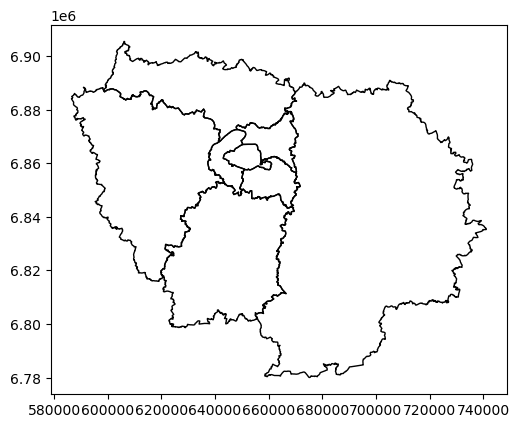

In [4]:
idf = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb").to_crs(CRS)
idf = idf[idf.code.isin(('75', '77', '78', '91', '92', '93', '94', '95'))]
idf.plot(fc='none')
plt.show()

In [5]:
def load_bd_alti_asc(path: str, extent=None) -> xr.Dataset:
    """
    Load BD Alti ASC files into an xarray DataArray.

    This function reads one or multiple ASC files, depending on whether a wildcard
    character ('*') is present in the path. It returns a merged xarray Dataset
    if multiple files are specified, otherwise a single DataArray

    Args:
        path (str): Path to the ASC file or files. If a wildcard character ('*') is present,
                    it loads all matching files and merges them.

    Returns:
        xr.Dataset: A Dataset containing the elevation data.
    """
    if '*' in path:
        paths = glob(path)
        ret = [load_bd_alti_asc(p) for p in tqdm(paths)]
        return xr.merge(ret)
    else:
        metadata = pd.read_csv(path, nrows=5, sep='\s+', header=None).set_index(0).to_dict()[1]
        data = pd.read_csv(path, sep='\s+', skiprows=6, header=None).astype(np.float32)
        x = (metadata['xllcorner'] + metadata['cellsize']*np.arange(metadata['ncols'])).astype(np.float32)
        y = (metadata['yllcorner'] + metadata['cellsize']*np.arange(metadata['nrows'])).astype(np.float32)
        ds = xr.DataArray(np.flip(data.values, axis=0), coords=[('y', y), ('x', x)], dims=['y', 'x'], name='alti')
        return ds


ds = load_bd_alti_asc(path, extent=idf.total_bounds)
ds

  0%|          | 0/33 [00:00<?, ?it/s]

<xarray.Dataset> Size: 168MB
Dimensions:  (y: 6000, x: 7000)
Coordinates:
  * y        (y) float32 24kB 6.775e+06 6.775e+06 ... 6.925e+06 6.925e+06
  * x        (x) float32 28kB 5.75e+05 5.75e+05 5.75e+05 ... 7.499e+05 7.5e+05
Data variables:
    alti     (y, x) float32 168MB nan nan nan nan nan ... nan nan nan nan nan

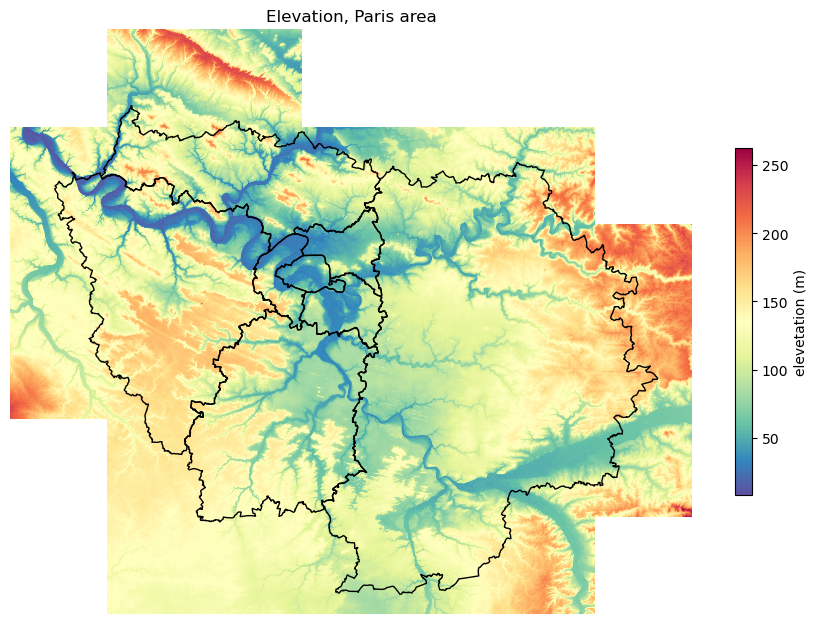

In [6]:
plt.figure(figsize=(11, 9))
plt.pcolormesh(ds.x, ds.y, ds['alti'].values, cmap='Spectral_r')
plt.colorbar(shrink=0.5, label='elevetation (m)')
idf.plot(ax=plt.gca(), fc='none')
plt.gca().axis('off')
plt.title("Elevation, Paris area")
plt.show()